In [58]:
import pickle

# load the scenario properties file
with open('../scenario-properties-baseline.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)
    

In [34]:
for species_group in scenario_properties.species.values():
    for species in species_group:
        print(f"Species: {species.sym_name}")
        print(f"Elliptical orbit: {species.elliptical}")


Species: S_148kg
Elliptical orbit: False
Species: S_750kg
Elliptical orbit: False
Species: S_1250kg
Elliptical orbit: False
Species: Sns
Elliptical orbit: False
Species: N_0.00141372kg
Elliptical orbit: True
Species: N_0.567kg
Elliptical orbit: True
Species: N_4kg
Elliptical orbit: True
Species: N_6kg
Elliptical orbit: True
Species: N_15kg
Elliptical orbit: True
Species: N_20kg
Elliptical orbit: True
Species: N_148kg
Elliptical orbit: True
Species: N_750kg
Elliptical orbit: True
Species: N_1250kg
Elliptical orbit: True
Species: B
Elliptical orbit: True


/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1340155212.py:12: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(file_path)



Species class distribution:
species_class
N          54704
S           7712
Sns         3356
B           2082
Unknown     1730
Name: count, dtype: int64
No unknown species classes found.
Number of objects for each species in T_new: species
N_0.00141372kg    52575
S_148kg            4972
Sns                3356
S_750kg            2148
B                  2082
N_0.567kg          1800
S_1250kg            592
N_4kg               101
N_1250kg             79
N_148kg              68
N_6kg                40
N_20kg               30
N_15kg                7
N_750kg               4
Name: count, dtype: int64


/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1340155212.py:95: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x0_summary = pd.DataFrame(index=range(scen_properties.n_shells), columns=scen_properties.species_names).fillna(0)
Processing Time Steps: 100%|██████████| 100/100 [00:00<00:00, 1182.08it/s]


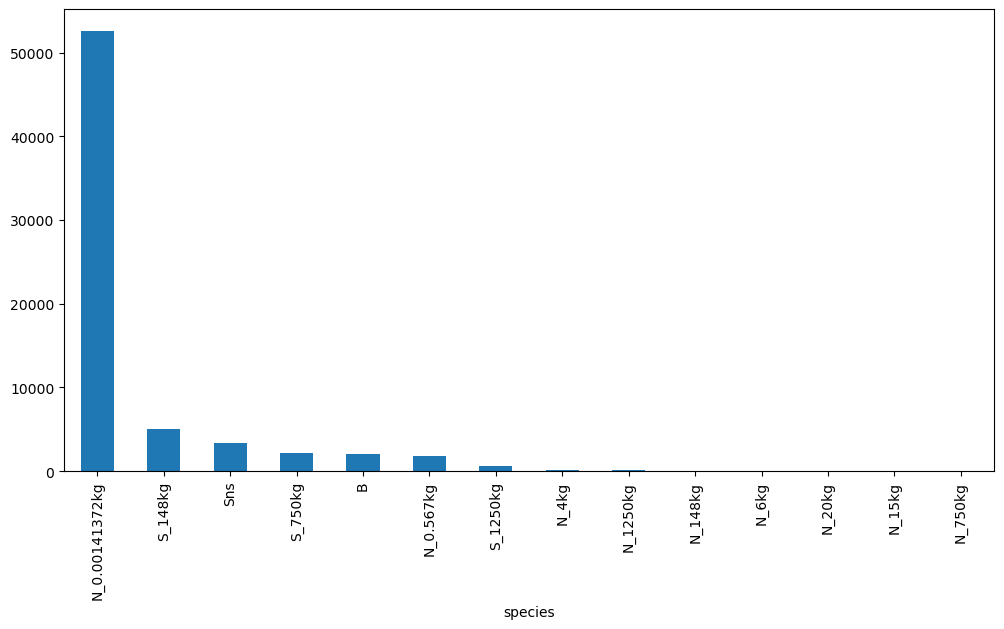

In [19]:
x0_summary, flm_steps, T_new = SEP_traffic_model(scenario_properties, '/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP1.csv')

/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/374937298.py:6: DtypeWarning: Columns (4,5) have mixed types. Specify dtype option on import or set low_memory=False.
  T = pd.read_csv(file_path)



Species class distribution:
species_class
N          54704
S           7712
Sns         3356
B           2082
Unknown     1730
Name: count, dtype: int64
No unknown species classes found.


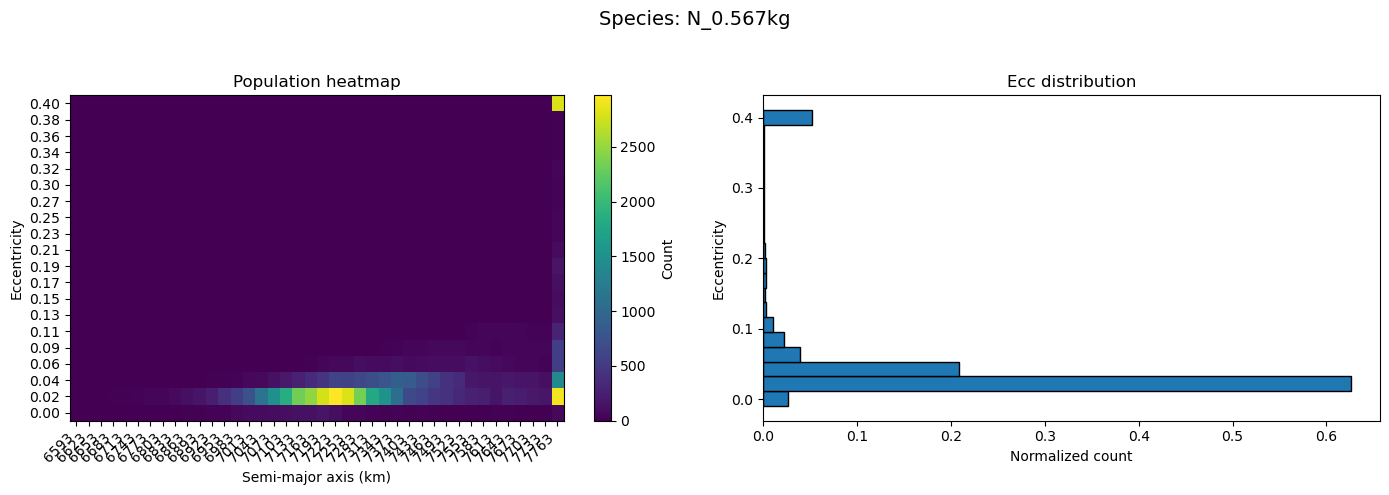

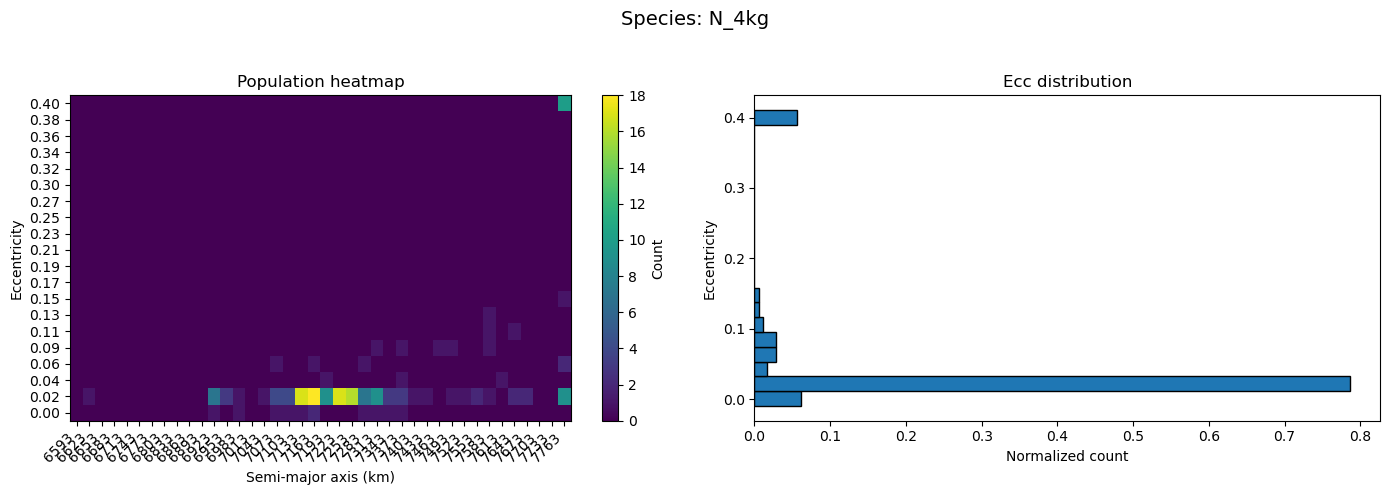

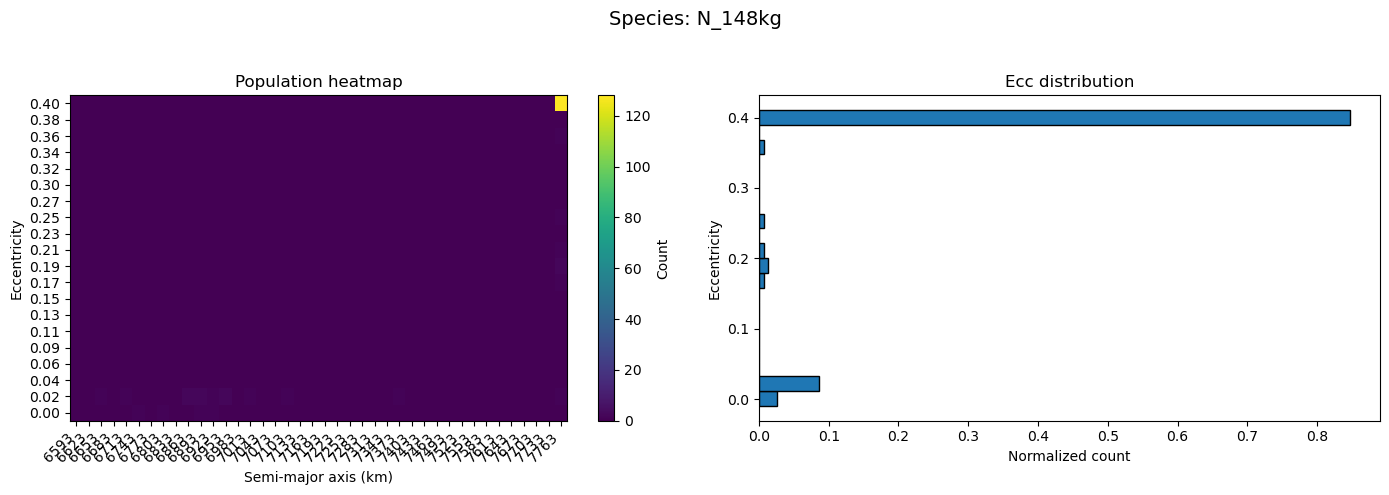

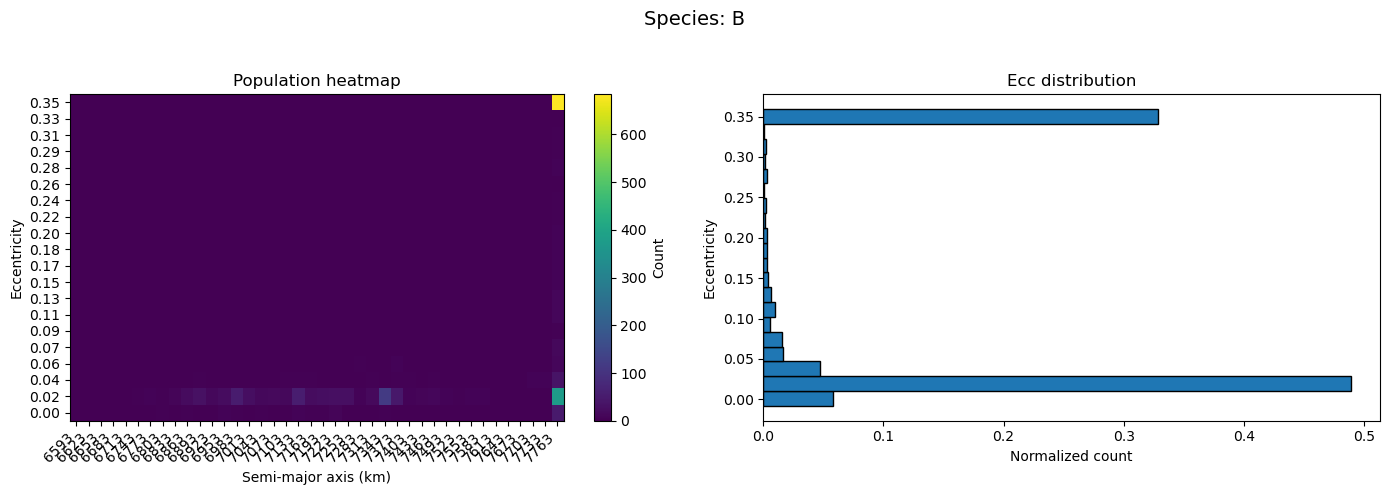

Number of objects for each species in T_new: species
N_0.567kg    54375
S             7712
B             2082
N_4kg          178
N_148kg        151
Name: count, dtype: int64


/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/374937298.py:137: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  x0_summary = pd.DataFrame(index=range(scen_properties.n_shells), columns=scen_properties.species_names).fillna(0)


In [59]:
import matplotlib.pyplot as plt
scen_properties = scenario_properties
file_path = '/Users/indigobrownhall/Code/pyssem/pyssem/utils/launch/data/ref_scen_SEP1.csv'

# Calculate Apogee, Perigee, and altitude
T = pd.read_csv(file_path)

T['apogee'] = T['sma'] * (1 + T['ecc'])
T['perigee'] = T['sma'] * (1 - T['ecc'])
T['alt'] = (T['apogee'] + T['perigee']) / 2 - scen_properties.re

T_new = assign_species_to_population(T, scen_properties.SEP_mapping)

# Bin altitudes
for species_class in T['species_class'].unique():
        if species_class in scen_properties.species_cells:
            if len(scen_properties.species_cells[species_class]) == 1:
                T_obj_class = T[T['species_class'] == species_class].copy()
                T_obj_class['species'] = scen_properties.species_cells[species_class][0].sym_name
                T_new = pd.concat([T_new, T_obj_class])
            else:
                species_cells = scen_properties.species_cells[species_class]
                T_obj_class = T[T['species_class'] == species_class].copy()
                T_obj_class['species'] = T_obj_class['mass'].apply(find_mass_bin, args=(scen_properties, species_cells)) 
                T_new = pd.concat([T_new, T_obj_class])

# find the sma x ecc distribution
for species_group in scen_properties.species.values():
        for species in species_group:
            if not species.elliptical:
                continue

            df_sp = T_new[T_new['species'] == species.sym_name]
            sma_bins = species.semi_major_axis_bins        # length = n_shells+1
            ecc_bins = species.eccentricity_bins          # length = n_ecc

            # digitize sma and ecc into 0..n_bin-1 indices
            i_sma = np.digitize(df_sp['sma'], sma_bins) - 1
            j_ecc = np.digitize(df_sp['ecc'], ecc_bins)

            # clamp to valid range
            i_sma = np.clip(i_sma, 0, scen_properties.n_shells-1)
            j_ecc = np.clip(j_ecc, 0, len(ecc_bins)-1)

            # build the 2D histogram
            pop2d = np.zeros((scen_properties.n_shells, len(ecc_bins)))
            for i,j in zip(i_sma, j_ecc):
                pop2d[i, j] += 1
            species.sma_ecc_pop = pop2d

            # collapse over sma to get the 1-D ecc‐distribution
            ecc_counts = pop2d.sum(axis=0)
            total = ecc_counts.sum()
            if total > 0:
                species.ecc_distribution = ecc_counts / total
            else:
                species.ecc_distribution = np.zeros_like(ecc_counts)

            name = getattr(species, "sym_name", repr(species))

            # inside your plotting loop, after pop2d and name are defined:

            fig, axes = plt.subplots(1, 2, figsize=(14, 5))
            fig.suptitle(f"Species: {name}", fontsize=14)

            # 1) heatmap of ECC × SMA population
            # pop2d.shape == (n_sma, n_ecc)
            n_sma, n_ecc = pop2d.shape

            im = axes[0].imshow(
                pop2d.T,
                origin="lower",
                aspect="auto",
                interpolation="none"
            )
            axes[0].set_title("Population heatmap")

            # set SMA‐bin midpoints on x‐axis
            sma_centers = scen_properties.sma_HMid_km  # length = n_sma
            axes[0].set_xticks(np.arange(n_sma))
            axes[0].set_xticklabels([f"{x:.0f}" for x in sma_centers], rotation=45, ha='right')
            axes[0].set_xlabel("Semi-major axis (km)")

            # set ECC‐bins on y‐axis (use midpoints if these are edges)
            ecc_bins = species.eccentricity_bins
            if len(ecc_bins) == n_ecc + 1:
                ecc_centers = 0.5 * (ecc_bins[:-1] + ecc_bins[1:])
            else:
                ecc_centers = ecc_bins
            axes[0].set_yticks(np.arange(n_ecc))
            axes[0].set_yticklabels([f"{e:.2f}" for e in ecc_centers])
            axes[0].set_ylabel("Eccentricity")

            plt.colorbar(im, ax=axes[0], label="Count")

            # 2) bar chart of ecc_distribution (horizontal, with ecc on y)
            axes[1].barh(
                ecc_centers,
                species.ecc_distribution,
                height=(ecc_centers[1] - ecc_centers[0] if len(ecc_centers)>1 else 0.1),
                edgecolor="black",
                align="center"
            )
            axes[1].set_xlabel("Normalized count")
            axes[1].set_ylabel("Eccentricity")
            axes[1].set_title("Ecc distribution")

            plt.tight_layout(rect=[0, 0, 1, 0.95])
            plt.show()

              
    

print(f"Number of objects for each species in T_new: {T_new['species'].value_counts()}")

T_new['epoch_start_datetime'] = T_new['year_start'].apply(
        lambda y: datetime(int(y), 1, 1)
    )
T_new['epoch_end_datetime'] = T_new['year_final'].apply(
    lambda y: datetime(int(y), 1, 1)
)

T_new['alt_bin'] = T_new['alt'].apply(find_alt_bin, args=(scen_properties,))

# Filter T_new to include only species present in scen_properties
T_new = T_new[T_new['species'].isin(scen_properties.species_names)]

# Initial population
x0 = T_new[T_new['epoch_start_datetime'] < scen_properties.start_date]

x0['species'].value_counts()

# Create a pivot table, keep alt_bin
df = x0.pivot_table(index='alt_bin', columns='species', aggfunc='size', fill_value=0)

# Create a new data frame with column names like scenario_properties.species_sym_names and rows of length n_shells
x0_summary = pd.DataFrame(index=range(scen_properties.n_shells), columns=scen_properties.species_names).fillna(0)
x0_summary.index.name = 'alt_bin'

# Merge counts into summary structure
x0_summary.update(df.reindex(columns=x0_summary.columns, fill_value=0))

# Fill remaining NaNs with 0
x0_summary.fillna(0, inplace=True)

# # Future Launch Model (updated)
# flm_steps = pd.DataFrame()

# time_increment_per_step = scen_properties.simulation_duration / scen_properties.steps

# time_steps = [
#     scen_properties.start_date + timedelta(days=365.25 * time_increment_per_step * i) 
#     for i in range(scen_properties.steps + 1)
# ]    

# for i, (start, end) in tqdm(enumerate(zip(time_steps[:-1], time_steps[1:])), total=len(time_steps) - 1, desc="Processing Time Steps"):

#     # Select objects that are launched during this time window
#     flm_step = T_new[
#         (T_new['epoch_start_datetime'] >= start) &
#         (T_new['epoch_start_datetime'] < end)
#     ]

#     # Group and reshape
#     flm_summary = flm_step.groupby(['alt_bin', 'species']).size().unstack(fill_value=0)

#     # Ensure all alt_bins are present
#     flm_summary = flm_summary.reindex(range(scen_properties.n_shells), fill_value=0)

#     flm_summary.reset_index(inplace=True)
#     flm_summary.rename(columns={'index': 'alt_bin'}, inplace=True)
#     flm_summary['epoch_start_date'] = start

#     flm_steps = pd.concat([flm_steps, flm_summary], ignore_index=True)


/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1169941010.py:43: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

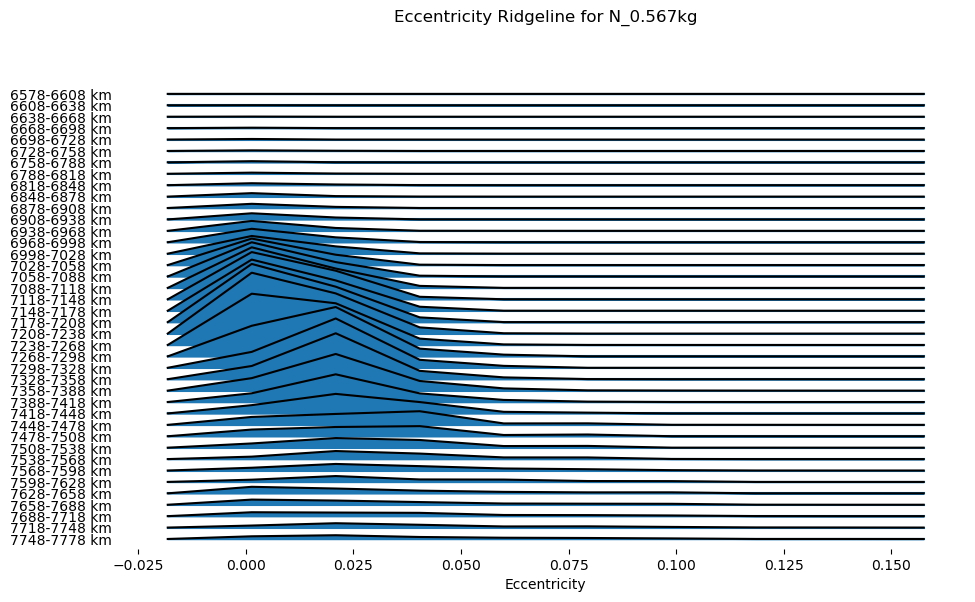

/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1169941010.py:43: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

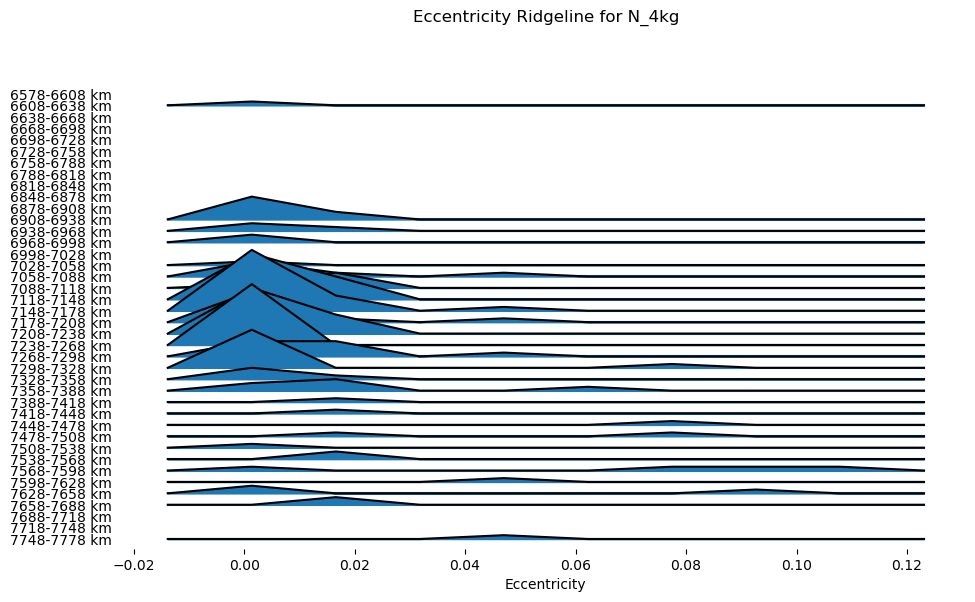

/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1169941010.py:43: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

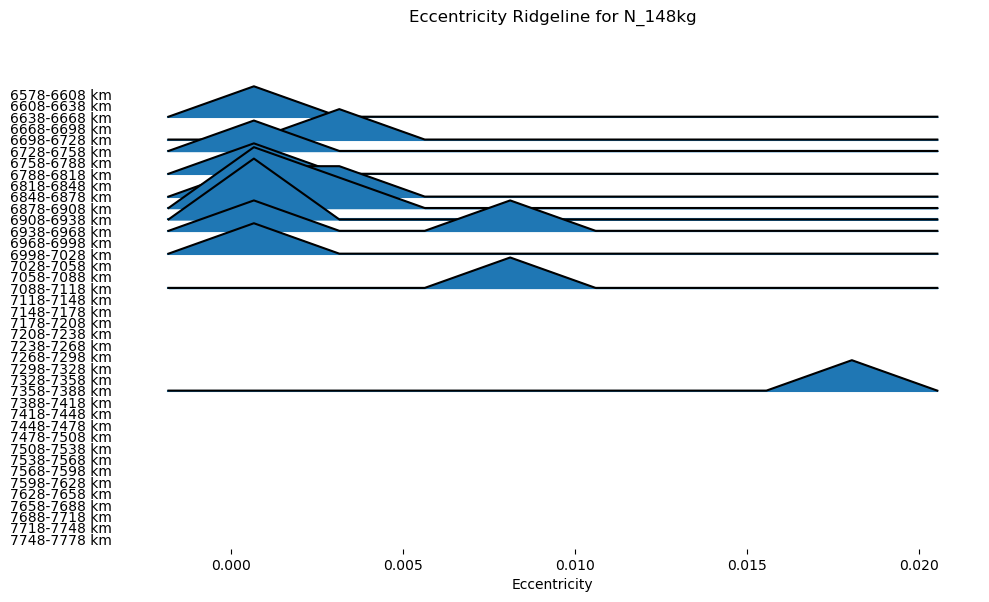

/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1169941010.py:43: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x600 with 0 Axes>

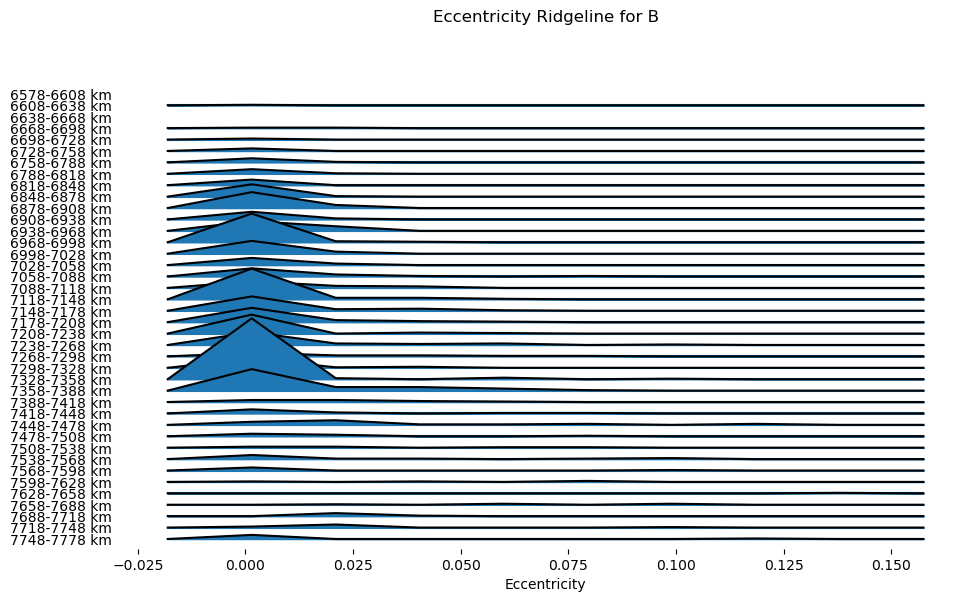

In [75]:
import pandas as pd
import joypy

for species_group in scen_properties.species.values():
    for species in species_group:
        if not species.elliptical:
            continue

        # pull out only this species’ objects
        df_sp = T_new[T_new['species'] == species.sym_name].copy()

        # bin definitions
        sma_bins = species.semi_major_axis_bins        # length = n_shells+1
        n_shells = scen_properties.n_shells
        # make human‐readable labels like "7000–7200 km"
        sma_labels = [
            f"{int(sma_bins[i])}-{int(sma_bins[i+1])} km"
            for i in range(n_shells)
        ]

        # assign a new categorical column 'sma_bin'
        df_sp['sma_bin'] = pd.cut(
            df_sp['sma'],
            bins=sma_bins,
            labels=sma_labels,
            include_lowest=True
        )

        name = species.sym_name

        # now plot the ridgeline (joyplot)
        plt.figure(figsize=(10, 6))
        joypy.joyplot(
            data=df_sp,
            by='sma_bin',
            column='ecc',
            kind='counts',      # use counts/density
            overlap=1.0,        # how much curves overlap
            figsize=(10, 6),
            title=f"Eccentricity Ridgeline for {name}"
        )
        plt.xlabel("Eccentricity")
        plt.tight_layout()
        plt.show()

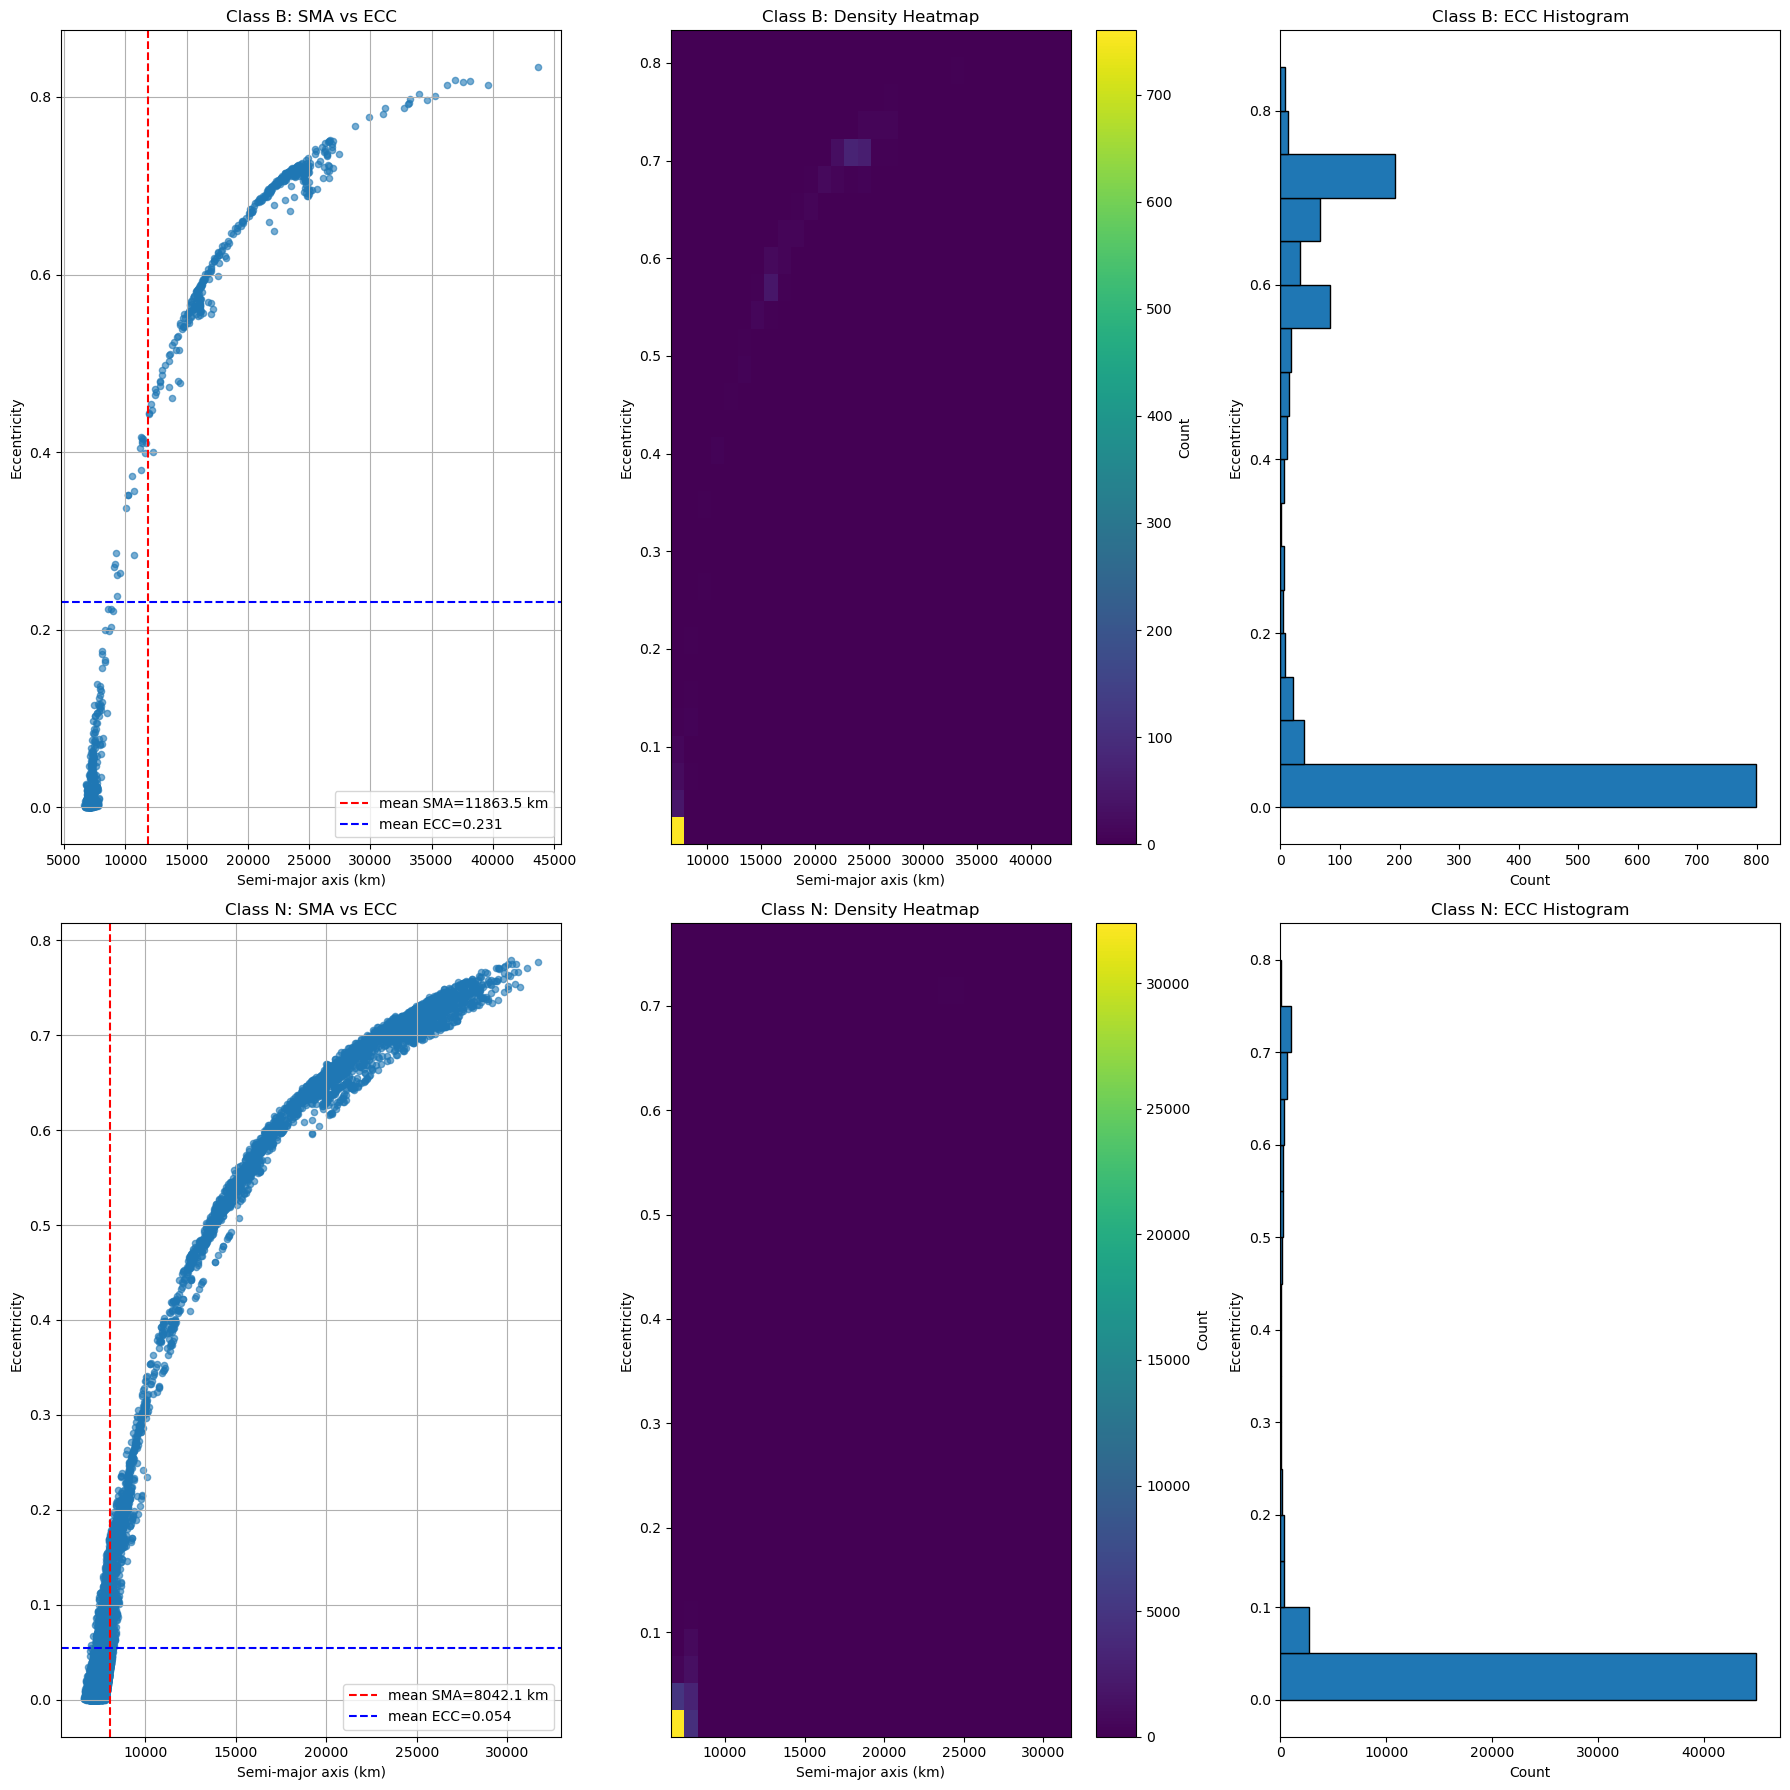

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Filter to LEO by perigee altitude
perigee_alt = T_new['perigee'] - scen_properties.re
T_LEO = T_new[(perigee_alt >= scen_properties.min_altitude) &
              (perigee_alt <= scen_properties.max_altitude)]

# Species classes to plot
classes = ['B', 'N']

# Create a 3×3 grid of subplots: scatter, heatmap, horizontal SMA histogram
fig, axes = plt.subplots(len(classes), 3, figsize=(18, 18))

for idx, cls in enumerate(classes):
    df_cls = T_LEO[T_LEO['species_class'] == cls]
    sma = df_cls['sma'].values
    ecc = df_cls['ecc'].values

    # Compute means
    mean_sma = np.nanmean(sma)
    mean_ecc = np.nanmean(ecc)

    # 1) Scatter plot with mean lines
    ax0 = axes[idx, 0]
    ax0.scatter(sma, ecc, s=20, alpha=0.6)
    ax0.axvline(mean_sma, color='red', linestyle='--', label=f"mean SMA={mean_sma:.1f} km")
    ax0.axhline(mean_ecc, color='blue', linestyle='--', label=f"mean ECC={mean_ecc:.3f}")
    ax0.set_xlabel('Semi-major axis (km)')
    ax0.set_ylabel('Eccentricity')
    ax0.set_title(f"Class {cls}: SMA vs ECC")
    ax0.legend(loc='best')
    ax0.grid(True)

    # 2) Density heatmap via 2D histogram
    ax1 = axes[idx, 1]
    counts, xedges, yedges = np.histogram2d(sma, ecc, bins=[30, 30])
    im = ax1.imshow(
        counts.T,
        origin='lower',
        aspect='auto',
        interpolation='none',
        extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]]
    )
    ax1.set_xlabel('Semi-major axis (km)')
    ax1.set_ylabel('Eccentricity')
    ax1.set_title(f"Class {cls}: Density Heatmap")
    plt.colorbar(im, ax=ax1, label='Count')


    # 3) Horizontal histogram of ECC
    ax2 = axes[idx, 2]
    if ecc.size > 0:
        # choose ECC bin width, e.g. 0.05
        bin_width = 0.05
        bins = np.arange(0, min(1.0, ecc.max()) + bin_width, bin_width)
        ax2.hist(ecc, bins=bins, orientation='horizontal', edgecolor='black')
    ax2.set_ylabel('Eccentricity')
    ax2.set_xlabel('Count')
    ax2.set_title(f"Class {cls}: ECC Histogram")

plt.tight_layout()
plt.show()


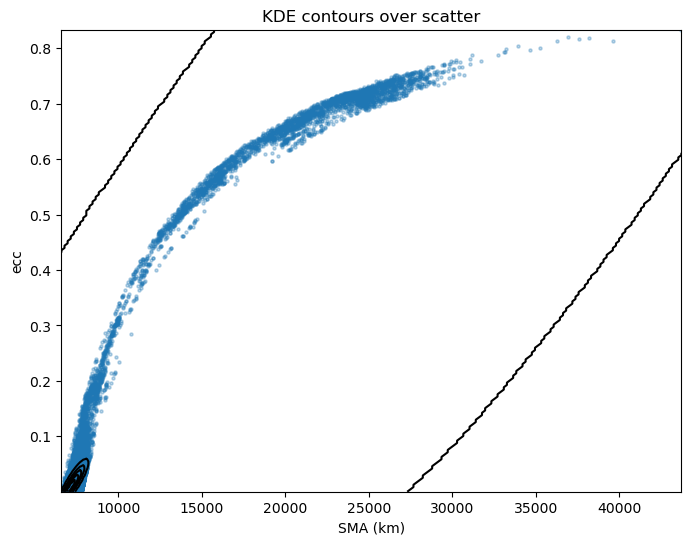

In [67]:
import numpy as np
from scipy.stats import gaussian_kde

x = T_LEO['sma'].values
y = T_LEO['ecc'].values
xy = np.vstack([x,y])
kde = gaussian_kde(xy)

# Create grid to evaluate KDE
xgrid = np.linspace(x.min(), x.max(), 200)
ygrid = np.linspace(y.min(), y.max(), 200)
X, Y = np.meshgrid(xgrid, ygrid)
Z = kde(np.vstack([X.ravel(), Y.ravel()])).reshape(X.shape)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x, y, s=5, alpha=0.3)
contours = ax.contour(
    X, Y, Z,
    levels=5,
    colors='k'
)
ax.set_xlabel('SMA (km)')
ax.set_ylabel('ecc')
ax.set_title('KDE contours over scatter')
plt.show()

In [73]:
!conda install joypy -y

Channels:
 - defaults
 - conda-forge
Platform: osx-arm64
Solving environment: done

## Package Plan ##

  environment location: /opt/anaconda3/envs/opus-env

  added / updated specs:
    - joypy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    joypy-0.2.4                |     pyhd8ed1ab_1          14 KB  conda-forge
    python-tzdata-2025.2       |     pyhd3eb1b0_0         141 KB
    pytz-2024.1                |  py310hca03da5_0         217 KB
    ------------------------------------------------------------
                                           Total:         372 KB

The following NEW packages will be INSTALLED:

  bottleneck         pkgs/main/osx-arm64::bottleneck-1.4.2-py310hbda83bc_0 
  joypy              conda-forge/noarch::joypy-0.2.4-pyhd8ed1ab_1 
  numexpr            pkgs/main/osx-arm64::numexpr-2.10.1-py310h5d9532f_0 
  pandas             pkgs/main/osx-arm64::pandas-2.2.3-p

/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:173: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = data.groupby(by)
/opt/anaconda3/envs/opus-env/lib/python3.10/site-packages/joypy/joyplot.py:234: UserWarning: At least a column/group has no numeric values.
  warn("At least a column/group has no numeric values.")
/var/folders/s7/wvhpsthj2y93nhzxmj7x1zw80000gn/T/ipykernel_5008/1400606334.py:39: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


<Figure size 1000x800 with 0 Axes>

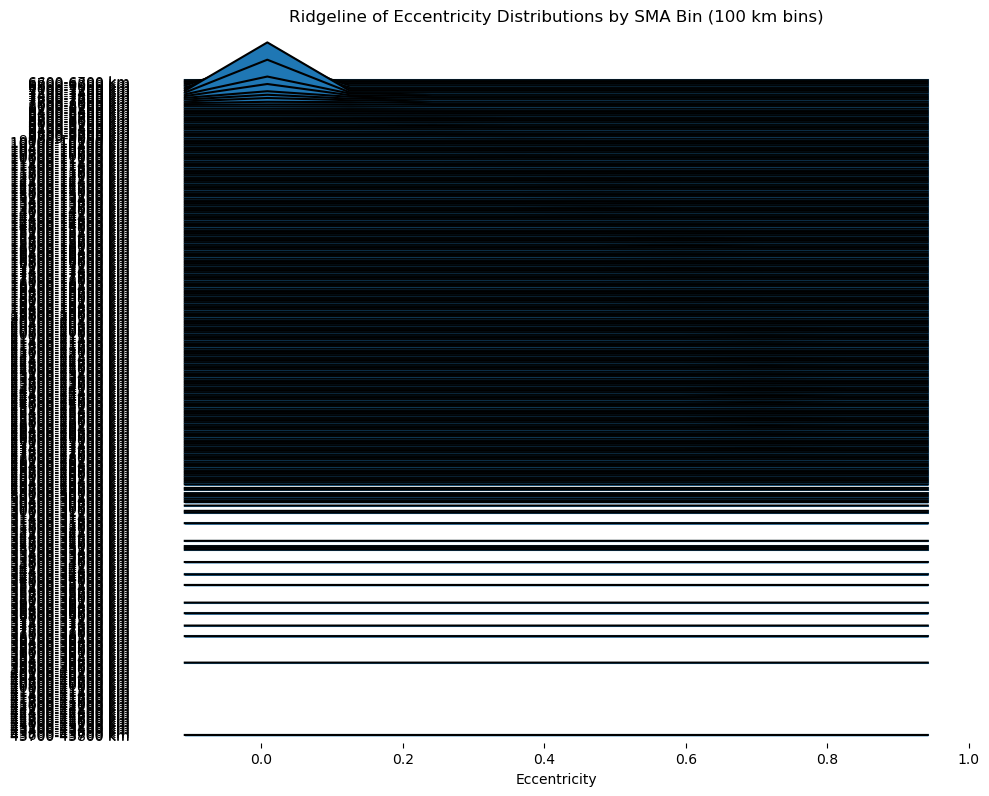

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joypy

# 1) Filter to LEO by perigee altitude
perigee_alt = T_new['perigee'] - scen_properties.re
T_LEO = T_new[(perigee_alt >= scen_properties.min_altitude) &
              (perigee_alt <= scen_properties.max_altitude)].copy()

# 2) Define your SMA bins (e.g. 100 km)
sma_min = np.floor(T_LEO['sma'].min() / 100) * 100
sma_max = np.ceil(T_LEO['sma'].max() / 100) * 100
sma_edges = np.arange(sma_min, sma_max + 100, 100)

# 3) Assign each object to a sma_bin label
sma_labels = [f"{int(sma_edges[i])}-{int(sma_edges[i+1])} km"
              for i in range(len(sma_edges)-1)]
T_LEO['sma_bin'] = pd.cut(
    T_LEO['sma'],
    bins=sma_edges,
    labels=sma_labels,
    include_lowest=True
)

# 4) Make the joyplot of eccentricity distributions by sma_bin
plt.figure(figsize=(10, 8))
joypy.joyplot(
    data=T_LEO,
    by='sma_bin',
    column='ecc',
    kind='counts',          # or 'values' if you want raw ecc values
    overlap=1.0,            # how much the curves overlap
    figsize=(10, 8),
    grid='--',
    title="Ridgeline of Eccentricity Distributions by SMA Bin (100 km bins)"
)
plt.xlabel('Eccentricity')
plt.tight_layout()
plt.show()

# Looking into collisions

In [37]:
import pickle

# load the scenario properties file
with open('../scenario-properties-baseline.pkl', 'rb') as f:
    scenario_properties_old = pickle.load(f)

In [41]:
import numpy as np

count = 0
for i in scenario_properties_old.species['active'][0].lambda_funs:
    count += np.nansum(i)

print(count)


scenario_properties_old.full_lambda[0]

156752.79675279677


[array([ 1.98000198,  0.99000099,  2.97000297,         nan,  2.97000297,
         2.97000297,  8.91000891,         nan,  6.93000693,  0.99000099,
         0.99000099,         nan,  3.96000396,  1.98000198,  0.99000099,
                nan, 11.88001188,  5.94000594,  0.99000099,         nan,
         1.98000198,  0.99000099,  2.97000297,         nan,  2.97000297,
         2.97000297,  8.91000891,         nan,  6.93000693,  0.99000099,
         0.99000099,         nan,  3.96000396,  1.98000198,  0.99000099,
                nan, 11.88001188,  5.94000594,  0.99000099,         nan,
         1.98000198,  0.99000099,  2.97000297,         nan,  2.97000297,
         2.97000297,  8.91000891,         nan,  6.93000693,  0.99000099,
         0.99000099,         nan,  3.96000396,  1.98000198,  0.99000099,
                nan, 11.88001188,  5.94000594,  0.99000099,         nan,
         1.98000198,  0.99000099,  2.97000297,         nan,  2.97000297,
         2.97000297,  8.91000891,         nan,  6.9

In [19]:
import pickle

# load the scenario properties file
with open('../collision_pairs.pkl', 'rb') as f:
    scenario_properties = pickle.load(f)

7028.1366
7028.1366
1
1


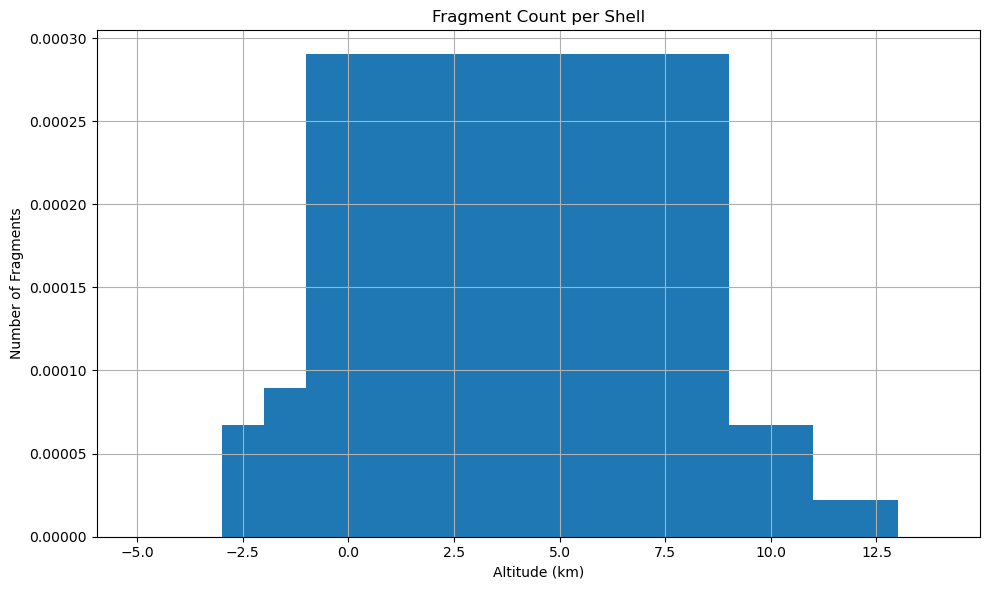

In [37]:
print(scenario_properties[15].collision_pair_by_shell[10].species2_sma)
print(scenario_properties[15].collision_pair_by_shell[10].species1_sma)
print(scenario_properties[15].collision_pair_by_shell[10].ecc2_index)
print(scenario_properties[15].collision_pair_by_shell[10].ecc1_index)
# print(scenario_properties[15].collision_pair_by_shell[0].fragments)
import matplotlib.pyplot as plt
import numpy as np
frags_2d = scenario_properties[15].collision_pair_by_shell[10].fragments.sum(axis=2)
frags_per_shell = scenario_properties[15].collision_pair_by_shell[10].fragments.sum(axis=(1, 2))  # shape: [n_shells]

# Optional: get shell altitude midpoints if available
altitudes = scenario_properties.HMid if hasattr(scenario_properties, "HMid") else np.arange(len(frags_per_shell))

# Plot
plt.figure(figsize=(10, 6))
plt.bar(altitudes, frags_per_shell, width=10)  # adjust width as needed
plt.xlabel("Altitude (km)")
plt.ylabel("Number of Fragments")
plt.title("Fragment Count per Shell")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
test = scenario_properties.

In [18]:
test.eqs

Matrix([
[0, 0, 7.80923179581143e-8*pi*N_4kg_1**2 + 8.58197290328293e-8*pi*N_4kg_10**2 + 8.85612381018689e-8*pi*N_4kg_2**2 + 8.93507173877859e-8*pi*N_4kg_3**2 + 8.97523111442916e-8*pi*N_4kg_4**2 + 8.98265920809846e-8*pi*N_4kg_5**2 + 8.98965858322802e-8*pi*N_4kg_6**2 + 8.99695244920988e-8*pi*N_4kg_7**2 + 9.00373218649521e-8*pi*N_4kg_8**2 + 8.84933832821452e-8*pi*N_4kg_9**2,  3.50124404599372e-11*pi*N_4kg_1**2 + 4.3891770154552e-11*pi*N_4kg_10**2 + 4.11709776445617e-11*pi*N_4kg_2**2 + 4.13908546737388e-11*pi*N_4kg_3**2 + 4.19828345610912e-11*pi*N_4kg_4**2 + 4.30767051683746e-11*pi*N_4kg_5**2 + 4.35258570185235e-11*pi*N_4kg_6**2 + 4.36224825570502e-11*pi*N_4kg_7**2 + 4.38798546573717e-11*pi*N_4kg_8**2 + 4.41291899094916e-11*pi*N_4kg_9**2, 0, 0],
[0, 0,   1.40025274069939e-7*pi*N_4kg_1**2 + 1.57196274564848e-7*pi*N_4kg_10**2 + 1.61157760977924e-7*pi*N_4kg_2**2 + 1.62594608081288e-7*pi*N_4kg_3**2 + 1.63334553378684e-7*pi*N_4kg_4**2 + 1.6373075683412e-7*pi*N_4kg_5**2 + 1.6382203855437e-7*pi*